In [1]:
# Basic
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import csv
import pickle

# SpikeInterface
import spikeinterface as si
import spikeinterface.extractors as se
from spikeinterface.preprocessing import get_motion_parameters_preset, get_motion_presets

# Local imports
import libs.utils.utils as utils
import libs.handle.dataset as handle_dataset
import libs.analysis.spikes as spikes

c:\Users\Sugimoto\Code\tc2025_shysgmt\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_behv_time(trials, event, procTeensy_to_imec):
    """
    Compute the time of stimulus, choice, and outcome for each trial.
    
    Parameters:
    trials (pd.DataFrame): DataFrame containing trial information.
    event (pd.DataFrame): DataFrame containing event information.
    procTeensy_to_imec (np.ndarray): Array mapping Teensy times to imec times.
    
    Returns:
    stim_time (np.ndarray): Array of stimulus times for each trial.
    choice_time (np.ndarray): Array of choice times for each trial.
    outcome_time (np.ndarray): Array of outcome times for each trial.
    """
    event_grouped = event.groupby('Trial')
    target_trials = trials['Trial'].dropna().astype(int).values

    stim_time = np.zeros(len(target_trials))
    choice_time = np.zeros(len(target_trials))
    outcome_time = np.zeros(len(target_trials))


    for i in range(0, len(target_trials)):

        df = event_grouped.get_group(target_trials[i])
        
        tf = (df['State'].isin([3, 4])) & (df['Column_name_changed'].isin(['Binary_photodiode']))
        row = df[tf]['Row_index'].values
        stim_time[i] = procTeensy_to_imec[row[0]]

        tf = (df['State'].isin([5, 6, 7, 8])) & (df['State'].shift(1).isin([3, 4]))
        row = df[tf]['Row_index'].values
        choice_time[i] = procTeensy_to_imec[row[0]]
        
        
        tf = df['Column_name_changed'].isin(['Dispenser'])&(df['Dispenser'] == 1)
        if tf.any():
            row = df[tf]['Row_index'].values
            outcome_time[i] = procTeensy_to_imec[row[0]]
        else:
            outcome_time[i] = np.nan
        
    # 
    behvior_time ={
        'trial': target_trials,
        'stim': stim_time,
        'choice': choice_time,
        'outcome': outcome_time
    }
        
    return behvior_time

In [3]:
# Generate a session object
session_dir = r'Z:\Data\RSS033\RSS033_241030_130923'
session = handle_dataset.Session(session_dir)

In [4]:
# Extract dataset of target probe
i_imec = 0
session.add_analyzer_clean(i_imec=i_imec)
session.add_procTeensy_to_imec(i_imec=i_imec)
session.add_event()

In [5]:
# Extact sorrting analyzer
sorting = session.analyzer_clean.sorting

In [6]:
unit_ids = sorting.get_unit_ids()
event = session.event
trials = session.trials
procTeensy_to_imec = session.procTeensy_to_imec
sampling_rate = sorting.sampling_frequency

In [7]:
behv_time = compute_behv_time(trials, event, procTeensy_to_imec) 
behv_time.keys()
behv_time['trial']

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [8]:
unit_id = unit_ids[100]
event_time = behv_time['choice']
spike_time = sorting.get_unit_spike_train(unit_id=unit_id)/sampling_rate

In [9]:
peth = spikes.compute_peth_array(
    spike_times=spike_time,
    event_times=event_time,
    bin_size=0.01,
    time_window=[-2, 3])

print('Trials', len(peth['trial']))
print(peth['trial'])
print('Bins', len(peth['bins']))
print(peth['bins'])
print('Spike counts', np.shape(peth['spike_counts']))
print(peth['spike_counts'])

Trials 522
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244

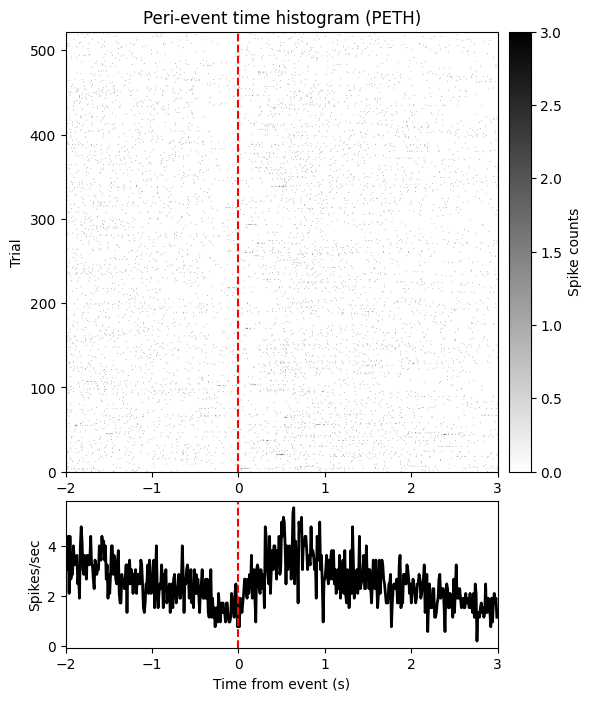

In [10]:
spikes.plot_peth(peth)

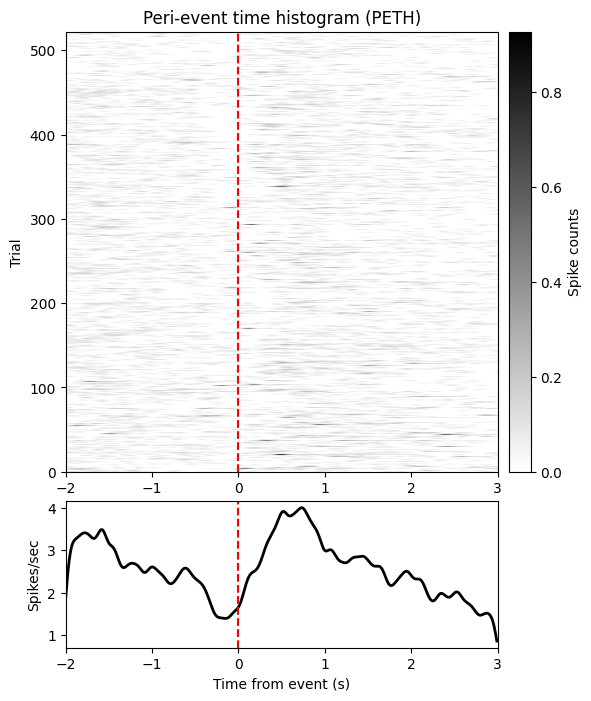

In [11]:
peth_smooth = spikes.compute_peth_smooth(peth, sigma_sec=0.05)
spikes.plot_peth(peth_smooth)

(-1.0, 2.0)

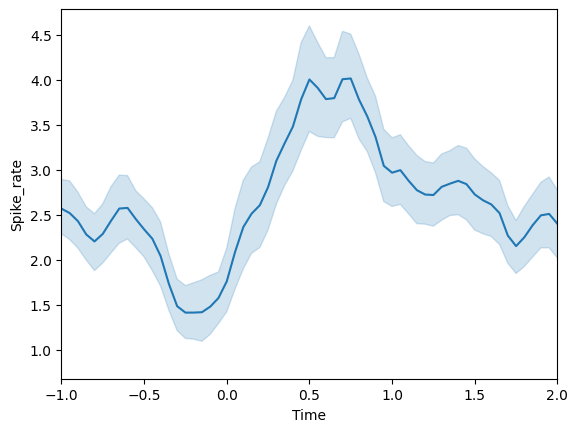

In [12]:
unit_id = unit_ids[100]
event_time = behv_time['choice']
spike_time = sorting.get_unit_spike_train(unit_id=unit_id)/sampling_rate

peth = spikes.compute_peth_array(
    spike_times=spike_time,
    event_times=event_time,
    bin_size=0.05,
    time_window=[-2, 3])

peth_smooth = spikes.compute_peth_smooth(peth, sigma_sec=0.05)
peth_fr = spikes.compute_peth_fr(peth_smooth)

peth_df = spikes.peth_to_longdf(peth_fr)

sns.lineplot(
    data=peth_df, 
    x='Time', 
    y='Spike_rate', 
)
plt.xlim([-1, 2])

In [13]:
trial_target = trials[['Trial', 'Stim', 'Choice', 'Correct']].dropna()
df = peth_df.merge(trial_target, on='Trial', how='left')
df

,Time,Trial,Spike_rate,Stim,Choice,Correct
0,-2.00,1,0.000000,right,right,True
1,-1.95,1,0.000000,right,right,True
2,-1.90,1,0.000000,right,right,True
3,-1.85,1,0.000000,right,right,True
4,-1.80,1,0.000000,right,right,True
...,...,...,...,...,...,...
52195,2.75,522,1.079823,right,right,True
52196,2.80,522,4.839429,right,right,True
52197,2.85,522,7.978869,right,right,True
52198,2.90,522,4.839429,right,right,True


(-1.0, 3.0)

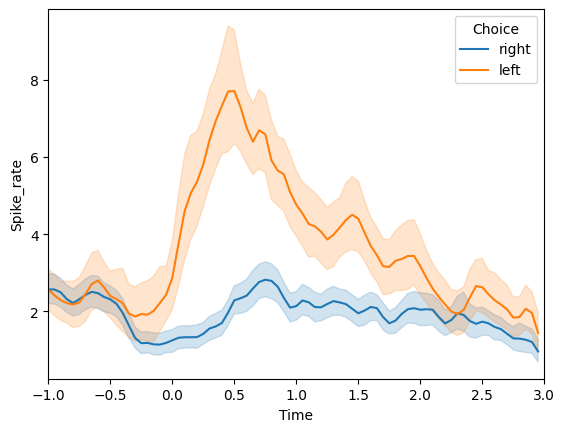

In [15]:
sns.lineplot(
    data=df, 
    x='Time', 
    y='Spike_rate',
    hue='Choice',
)
plt.xlim([-1, 3])